In [84]:
import os
os.listdir()

['Untitled.ipynb', '32_2017.xlsx', '.ipynb_checkpoints']

In [85]:
import pandas as pd
df = pd.read_excel('32_2017.xlsx')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
Timestamp    144 non-null object
INV01 ACT    144 non-null float64
INV01 EXP    144 non-null float64
Shading      144 non-null object
dtypes: float64(2), object(2)
memory usage: 4.6+ KB
None


In [3]:
df.head()

,Timestamp,INV01 ACT,INV01 EXP,Shading
0,2017-10-04 00:00:00,0.1,0.0,No
1,2017-10-04 00:10:00,0.1,0.0,No
2,2017-10-04 00:20:00,0.1,0.0,No
3,10/4/2017 0:30,0.1,0.0,No
4,2017-10-04 00:40:00,0.1,0.0,No


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
Timestamp    144 non-null object
INV01 ACT    144 non-null float64
INV01 EXP    144 non-null float64
Shading      144 non-null object
dtypes: float64(2), object(2)
memory usage: 4.6+ KB


In [46]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Shading'] = df['Shading'].map({
    'No': 0,
    'Yes': 1})

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
Timestamp    144 non-null datetime64[ns]
INV01 ACT    144 non-null float64
INV01 EXP    144 non-null float64
Shading      144 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 4.6 KB


In [48]:
X = df[['Timestamp', 'INV01 ACT', 'INV01 EXP']]

y = df['Shading']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)


In [49]:
labels = {1 : 'Yes', 2 : 'No'}

In [63]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [51]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 139 to 37
Data columns (total 3 columns):
Timestamp    100 non-null datetime64[ns]
INV01 ACT    100 non-null float64
INV01 EXP    100 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.1 KB


In [54]:
for x in X_train:
        print(x)

Timestamp
INV01 ACT
INV01 EXP


In [55]:
X.columns

Index(['Timestamp', 'INV01 ACT', 'INV01 EXP'], dtype='object')

In [57]:
# Loop through datasets

cols = ['INV01 ACT', 'INV01 EXP']

for x in cols:
    X_train_new.append([float(ts) for ts in X_train[x]])
    
for y in y_train:
    y_train_new.append(int(y))
    
for x in cols:
    X_test_new.append([float(ts) for ts in X_test[x]])
    
for y in y_test:
    y_test_new.append(int(y))
    
# Convert to numpy for efficiency
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)
X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

In [65]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)


In [66]:
m

In [81]:
m.fit(X_train, y_train)


In [82]:
label, proba = m.predict(X_test)


TypeError: unhashable type: 'slice'

In [74]:
label


array([0, 0])

In [75]:
proba

array([1., 1.])

In [76]:
label

array([0, 0])

In [80]:
label.shape

(2,)

In [79]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label, y_test_new,
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test[::10])

conf_mat

ValueError: Found input variables with inconsistent numbers of samples: [2, 44]

In [109]:
import pandas as pd
df = pd.read_excel('32_2017.xlsx')
print(df.info())

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Shading'] = df['Shading'].map({'No': 0, 'Yes': 1})

#X = df[['Timestamp', 'INV01 ACT', 'INV01 EXP']]

X = df[['INV01 ACT', 'INV01 EXP']]
y = df['Shading']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
Timestamp    144 non-null object
INV01 ACT    144 non-null float64
INV01 EXP    144 non-null float64
Shading      144 non-null object
dtypes: float64(2), object(2)
memory usage: 4.6+ KB
None


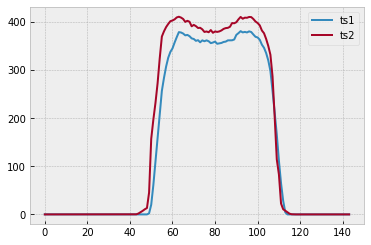

In [110]:
ts1 = df['INV01 ACT']
ts2 = df['INV01 EXP']

import matplotlib.pyplot as plt
ts1.plot()
ts2.plot()


plt.legend(['ts1','ts2'])
plt.show()

In [111]:
#Euclidean distance

In [112]:
from math import sqrt

def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))

In [113]:
euclid_dist(ts1, ts2)

411.07969677423876

In [114]:
#Dynamic Time Warping

#Dynamic time warping finds the optimal non-linear alignment between two time series

#

In [115]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [116]:
print(DTWDistance(ts1,ts2))


157.57971094020942


In [117]:
#faster version of DTW

def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [118]:
print(DTWDistance(ts1,ts2,20))


174.59570871015123


In [119]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return sqrt(LB_sum)

In [120]:
print(LB_Keogh(ts1,ts2,20))


60.539667987196644


In [151]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [152]:
train_ = pd.concat([X_train, y_train], axis = 1)
train_.shape

(100, 3)

In [169]:
test_ = pd.concat([X_test, y_test], axis = 1)
test_.shape

(44, 3)

In [170]:
X_test.shape

(44, 2)

In [154]:
train_.head()

,INV01 ACT,INV01 EXP,Shading
139,0.00,0.00,0
99,369.08,400.89,0
54,205.96,324.29,0
51,60.84,196.77,0
98,373.82,406.05,0


In [171]:
print(knn(train_.values,test_.values,4))


             precision    recall  f1-score   support

        0.0       0.97      0.95      0.96        40
        1.0       0.60      0.75      0.67         4

avg / total       0.94      0.93      0.94        44

